In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Recommender systems

Typical machine learning datasets are of the form:

$$
\begin{array}{cc}
  input&target\\
  \mathbf{x}_1&y_1\\
  \mathbf{x}_2&y_2\\  
  \vdots & \vdots \\
  \mathbf{x}_N&y_N
\end{array}
$$

a set of input vectors ($\mathbf{x}_i$) and their associated targets ($y_i$), that we would like to predict.

Here it is easy to use standard algorithms like linear regression.

In recommendation probles, the dataset can be better viewed as:
$$
\begin{array}{ccc}
  user&item&rating\\
  u_1&v_1&r(u_1, v_1)\\
  \vdots & \vdots \\
  u_N&v_N&r(u_N, v_N)
\end{array}
$$

which is a set of triplets of users, items and ratings which tell us what rating users gave to certain items. These items can be different for all users, so we never had the "full" picture.

You can visualize this as a matrix completion problem:

<img src="images/rating_matrix1.png" height="500" width="500">

Alot of ratings are actually missing from this matrix. They are not zero, they are simply missing.

## Load the MovieLens small dataset

http://grouplens.org/datasets/movielens/
> GroupLens Research has collected and made available rating data sets from the MovieLens web site (http://movielens.org). The data sets were collected over various periods of time, depending on the size of the set. 
> 
> Small: 100,000 ratings and 1,300 tag applications applied to 9,000 movies by 700 users. Last updated 10/2016.

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tag_headers = ['user_id', 'movie_id', 'tag', 'timestamp']
tags = pd.read_csv('../data/tags.csv')
rating_headers = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('../data/ratings.csv')
movie_headers = ['movie_id', 'title', 'genres']
movies = pd.read_csv('../data/movies.csv')
movie_titles = movies.title.tolist()

In [66]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [67]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


In [68]:
tags.head()

,userId,movieId,tag,timestamp
0,12,16,20060407,1144396544
1,12,16,robert de niro,1144396554
2,12,16,scorcese,1144396564
3,17,64116,movie to see,1234720092
4,21,260,action,1428011080


In [69]:
df = movies.join(ratings, on=['movieId'], rsuffix='_r').join(tags, on=['movieId'], rsuffix='_t')
del df['movieId_r']
del df['userId_t']
del df['movieId_t']
del df['timestamp_t']

In [70]:
df.head()

,movieId,title,genres,userId,rating,timestamp,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,1.5,1.217896e+09,robert de niro
1,2,Jumanji (1995),Adventure|Children|Fantasy,1.0,4.0,1.217896e+09,scorcese
2,3,Grumpier Old Men (1995),Comedy|Romance,1.0,4.0,1.217897e+09,movie to see
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1.0,4.0,1.217897e+09,action
4,5,Father of the Bride Part II (1995),Comedy,1.0,4.0,1.217896e+09,politics


In [83]:
# How many users?
print(data.userId.nunique(), 'users')

# How many movies?
print(data.movieId.nunique(), 'movies')

# How possible ratings?
print(data.userId.nunique() * data.movieId.nunique(), 'possible ratings')

# How many entries are present?
print(len(data), 'ratings')
print(100 * (float(len(data)) / (data.userId.nunique() * data.movieId.nunique())), '% of possible ratings')

668 users
10325 movies
6897100 possible ratings
105339 ratings
1.5272940801206305 % of possible ratings


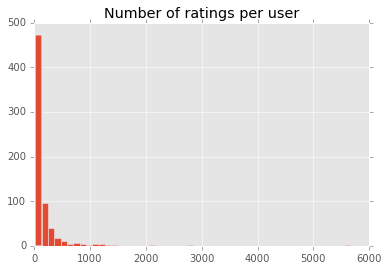

In [12]:
# Number of ratings per users
fig = plt.figure()
ax = plt.hist(data.groupby('userId').apply(lambda x: len(x)).values, bins=50)
plt.title("Number of ratings per user")
fig.show()

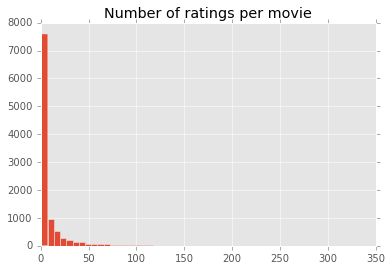

In [13]:
# Number of ratings per movie
fig = plt.figure()
ax = plt.hist(data.groupby('movieId').apply(lambda x: len(x)).values, bins=50)
plt.title('Number of ratings per movie')
fig.show()

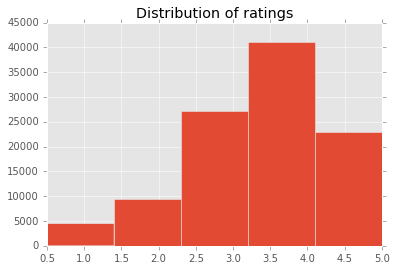

In [14]:
# Ratings distribution
fig = plt.figure()
ax = plt.hist(data.rating.values, bins=5)
plt.title("Distribution of ratings")
fig.show()

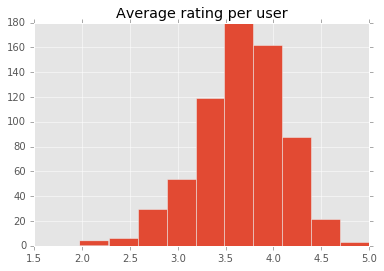

In [15]:
# Average rating per user
fig = plt.figure()
ax = plt.hist(data.groupby('userId').rating.mean().values, bins=10)
plt.title("Average rating per user")
fig.show()

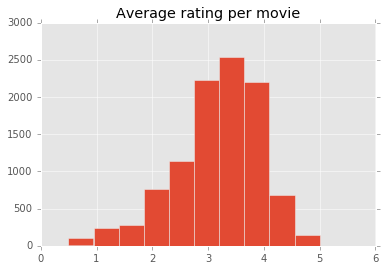

In [16]:
# Average rating per movie
fig = plt.figure()
ax = plt.hist(data.groupby('movieId').rating.mean().values, bins=10)
plt.title('Average rating per movie')
fig.show()

### Robust Top Movies - Lets weight the average rating by the square root of number of ratings


In [10]:
top_movies = data.groupby('movieId').apply(lambda x:len(x)**0.5 * x.mean()).sort_values('rating', ascending=False).head(10)
pd.concat([movies.loc[top_movies.index.values], 
           average_movie_rating.loc[top_movies.index.values].rating], axis=1)

,title,genres,rating
movieId,,,
318,"Shawshank Redemption, The (1994)",Crime|Drama,4.454545
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.160000
356,Forrest Gump (1994),Comedy|Drama|Romance|War,4.138264
593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.194828
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.188645
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.264368
527,Schindler's List (1993),Drama|War,4.296371
50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.328947
110,Braveheart (1995),Action|Drama|War,4.108871


In [11]:
controversial_movies = data.groupby('movieId').apply(lambda x:len(x)**0.25 * x.std()).sort_values('rating', ascending=False).head(10)
pd.concat([movies.loc[controversial_movies.index.values], 
           average_movie_rating.loc[controversial_movies.index.values].rating], axis=1)

,title,genres,rating
movieId,,,
344,Ace Ventura: Pet Detective (1994),Comedy,2.849711
231,Dumb & Dumber (Dumb and Dumber) (1994),Adventure|Comedy,3.003356
1721,Titanic (1997),Drama|Romance,3.356209
1206,"Clockwork Orange, A (1971)",Crime|Drama|Sci-Fi|Thriller,3.865672
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.160000
480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,3.659864
356,Forrest Gump (1994),Comedy|Drama|Romance|War,4.138264
94439,Jumping the Broom (2011),Comedy,2.750000
60291,Gonzo: The Life and Work of Dr. Hunter S. Thom...,Documentary,2.750000


In [84]:
rp = df.pivot_table(columns=['movieId'],index=['userId'],values='rating')
rp = rp.fillna(0); # Replace NaN
rp.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,104913,104925,104944,104947,104956,105197,105211,105213,105223,105266
userId,,,,,,,,,,,,,,,,,,,,,
1.0,1.5,4.0,4.0,4.0,4.0,3.0,4.0,3.0,0.5,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We would like to produce estimates $\tilde{r}$ for all the missing ratings

<img src="images/rating_matrix2.png" height="500" width="500">

## Some ideas:

### Mean filling: prediction is the average rating a given item.
 - Simple and efficient
 - Impersonal; everyone gets same predictions
 - Imprecise for movies with few ratings

### Content filtering: perform feature engineering on each item and build a model for each user using these features
 - Requires careful feature engineering of items
 - As many classifiers as users (could be thousands)
 - Information is not shared across users

### Matrix factorization: discover hidden attributes of the items and each user's preference for these attributes
 - AKA latent embedding
 - Latent variables are sometimes called "factors", "concepts", or "topics"
 - Imagine that each item has a set of hidden attributes, and users have preferences for each of these attributes. The estimated rating could be the linear combination of the attributes and preferences (dot product).
 
 
Completing the user-item rating matrix by sharing information across rows (users) and columns (items) is referred to as **collaborative filtering**

<img src="images/rating_matrix3.png" height="500" width="500">

This is like decomposing the matrix...

<img src="images/factorization.svg" height="700" width="700">

### Matrix factorization via alternating least squares (ALS)

We have users $u$ for items $i$ in a matrix

$$ Q_{ui} = \cases{
r  &amp; \text{if user u rate item i} \cr
0 &amp; \text{if user u did not rate item i}
} $$
where $r$ is what rating values can be. 

We want to *learn* the **factor matrices** for movies $Y \in \mathbb{R}^{f \times n}$ (each movie is a column vector) and for users $X \in \mathbb{R}^{m \times f}$ (each user is a row vector) such that
$$
Q \approx Y X
$$

We have two unknown variables. Therefore, we will adopt an **alternating least squares** approach:
 - Randomly initialize $X$ and $Y$
 - Estimate $Y$ using $X$
 - Estimate $X$ by using $Y$
 - Iterate until convergence
 
**Problem**: $X$ and $Y$ are missing entries!
 - May want to penalize the movies that do not have ratings in the update rule.
 - Removes making assumptions around the movies that are not rated
To do this, introduce **weight matrix** $W$ where:
$$
w_{ui} = \cases{
0 &amp;\text{if  } q_{ui} = 0 \cr
1 &amp; \text{ else} 
}
$$

Then, cost functions that we are trying to minimize is in the following:
$$ J(x_u) = (q_u - x_u Y) W_u (q_u - x_u Y)^T + \lambda x_u x_u^T $$
$$ J(y_i) = (q_i - X y_i) W_i (q_i - X y_i)^T + \lambda y_i y_i^T $$

$\lambda$ is a regularization term to avoid overfitting; it penalizes very large values of $x$ and $y$.

Gradient descent could be used, but regularized least squares has a closed-form solution which is more efficient to use:
$$ x_u = (Y W_u Y^T + \lambda I)^{-1} Y W_u q_u $$
$$ y_i = (X^T Wi X + \lambda I)^{-1} X^T W_i q_i $$
where $W_u \in \mathbb{R}^{nxn}$ and $W_u \in \mathbb{R}^{mxm}$ diagonal matrices.

## Implementation

In [73]:
Q = rp.values
Q

array([[ 1.5,  4. ,  4. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       ..., 
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  1.5,  2.5,  3. ]])

In [74]:
Q.shape

(456, 9796)

In [75]:
W = Q>0.5
W[W == True] = 1
W[W == False] = 0
# To be consistent with our Q matrix
W = W.astype(np.float64, copy=False)

In [76]:
W

array([[ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  1.,  1.]])

### Parameters

In [77]:
lambda_ = 0.1
n_factors = 100
m, n = Q.shape
n_iterations = 20

In [78]:
X = 5 * np.random.rand(m, n_factors) 
Y = 5 * np.random.rand(n_factors, n)

In [79]:
def get_error(Q, X, Y, W):
    return np.sum((W * (Q - np.dot(X, Y)))**2)

In [80]:
errors = []
for ii in range(n_iterations):
    X = np.linalg.solve(np.dot(Y, Y.T) + lambda_ * np.eye(n_factors), 
                        np.dot(Y, Q.T)).T
    Y = np.linalg.solve(np.dot(X.T, X) + lambda_ * np.eye(n_factors),
                        np.dot(X.T, Q))
    print('{}th iteration is completed'.format(ii))
    errors.append(get_error(Q, X, Y, W))
Q_hat = np.dot(X, Y)
print('Error of rated movies: {}'.format(get_error(Q, X, Y, W)))

0th iteration is completed
1th iteration is completed
2th iteration is completed
3th iteration is completed
4th iteration is completed
5th iteration is completed
6th iteration is completed
7th iteration is completed
8th iteration is completed
9th iteration is completed
10th iteration is completed
11th iteration is completed
12th iteration is completed
13th iteration is completed
14th iteration is completed
15th iteration is completed
16th iteration is completed
17th iteration is completed
18th iteration is completed
19th iteration is completed
Error of rated movies: 27948.836834907157


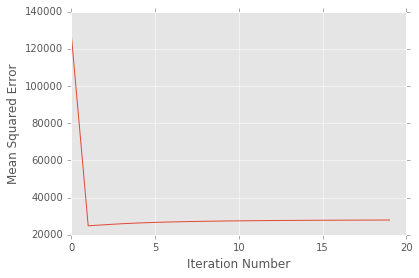

In [81]:
plt.plot(errors);
plt.xlabel('Iteration Number');
plt.ylabel('Mean Squared Error');

In [86]:
def print_recommendations(limit=100, W=W, Q=Q, Q_hat=Q_hat, movie_titles=movie_titles):
    #Q_hat -= np.min(Q_hat)
    #Q_hat[Q_hat < 1] *= 5
    Q_hat -= np.min(Q_hat)
    Q_hat *= float(5) / np.max(Q_hat)
    movie_ids = np.argmax(Q_hat - 5 * W, axis=1)
    for jj, movie_id in list(zip(range(m), movie_ids))[:limit]:
        #if Q_hat[jj, movie_id] < 0.1: continue
        print('User {} liked {}\n'.format(jj + 1, ', '.join([movie_titles[ii] for ii, qq in enumerate(Q[jj]) if qq > 3])))
        print('User {} did not like {}\n'.format(jj + 1, ', '.join([movie_titles[ii] for ii, qq in enumerate(Q[jj]) if qq < 3 and qq != 0])))
        print('\n User {} recommended movie is {} - with predicted rating: {}'.format(
                    jj + 1, movie_titles[movie_id], Q_hat[jj, movie_id]))
        print('\n' + 100 *  '-' + '\n')
print_recommendations()

User 1 liked Jumanji (1995), Grumpier Old Men (1995), Waiting to Exhale (1995), Father of the Bride Part II (1995), Sabrina (1995), GoldenEye (1995), Dracula: Dead and Loving It (1995), Cutthroat Island (1995), Casino (1995), Sense and Sensibility (1995), Get Shorty (1995), Copycat (1995), Assassins (1995), Powder (1995), Leaving Las Vegas (1995), Now and Then (1995), City of Lost Children, The (Cité des enfants perdus, La) (1995), Shanghai Triad (Yao a yao yao dao waipo qiao) (1995), Twelve Monkeys (a.k.a. 12 Monkeys) (1995), Babe (1995), Carrington (1995), Dead Man Walking (1995), Clueless (1995), Cry, the Beloved Country (1995), Richard III (1995), Dead Presidents (1995), Restoration (1995), Mortal Kombat (1995), To Die For (1995), How to Make an American Quilt (1995), Seven (a.k.a. Se7en) (1995), Pocahontas (1995), When Night Is Falling (1995), Usual Suspects, The (1995), Mighty Aphrodite (1995), Big Green, The (1995), Georgia (1995), Indian in the Cupboard, The (1995), Eye for an 